## Working with OOI NetCDF Data

In this example we will learn how to programatically download and work with OOI NetCDF data from within the notebook. We will use data from the 3D Thermistory Array deployed in the ASHES Vent field at Axial Seamount for this example, but the mechanics apply to all datasets that are processed through the OOI Cyberinfrastructure (CI) system. You wil learn:

* how to find the data you are looking for
* how to use the machine to machine API to request data
* how to load the NetCDF data into your notebook, once the data request has completed
* how to explore and plot data

The difference between a NetCDF and JSON data request is that NetCDF files are served asynchronously and delivered to a THREDDS server, while the JSON data response is synchronous (instantaneous) and served as a JSON object in the GET response. NetCDF data is undecimated (full data set), while the JSON response is decimated down to a maximum of 20,000 data points.

Login in at https://ooinet.oceanobservatories.org/ and obtain your <b>API username and API token</b> under your profile (top right corner).

In [1]:
username =''
token = ''

Optionally, you can handle authentication outside the notebook by setting up a .netrc file in your home directory and loading it with your bash profile. Open your terminal
```
$ touch .netrc
$ chmod 700 .netrc
$ vim .netrc

```
Add the following your your .netrc file:

```
machine ooinet.oceanobservatories.org
login OOIAPI-TEMPD1SPK4K0X
password TEMPCXL48ET2XT
```

Use your username and token. Save the file and uncomment the following cell.

In [1]:
import netrc
netrc = netrc.netrc()
remoteHostName = "ooinet.oceanobservatories.org"
info = netrc.authenticators(remoteHostName)
username = info[0]
token = info[2]

### Part One: Finding and requesting the data.

In [2]:
import requests
import time

The ingredients being used to build the data_request_url can be found here. For this example, we will use the data from the 3D Thermistor Array (TMPSF)
http://ooi.visualocean.net/instruments/view/RS03ASHS-MJ03B-07-TMPSFA301

![RS03ASHS-MJ03B-07-TMPSFA301](https://github.com/friedrichknuth/ooi_data_analysis/raw/master/qc_db_images/RS03ASHS-MJ03B-07-TMPSFA301.png)

In [3]:
subsite = 'RS03ASHS'
node = 'MJ03B'
sensor = '07-TMPSFA301'
method = 'streamed'
stream = 'tmpsf_sample'
beginDT = '2014-09-27T01:01:01.000Z' #begin of first deployement
endDT = None

Send the data request.

In [4]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}
r = requests.get(data_request_url, auth=(username, token))
data = r.json()

The first url in the response is the location on THREDDS where the data is being served. We will get back to using the THREDDS location later.

In [5]:
print(data['allURLs'][0])

https://opendap.oceanobservatories.org/thredds/catalog/ooi/cbps@uw.edu/20180221T221135-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/catalog.html


The second url in the response is the regular APACHE server location for the data.

In [6]:
print(data['allURLs'][1])

https://opendap.oceanobservatories.org/async_results/cbps@uw.edu/20180221T221135-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample


We will use this second location to programatically check for a status.txt file to be written, containing the text 'request completed'. This indicates that the request is completed and the system has finished writing out the data to this location. This step may take a few minutes.

In [7]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 1.25 s, sys: 56 ms, total: 1.31 s
Wall time: 1min


## Part Two: Loading the data into the notebook.

In [8]:
import re
import xarray as xr
import pandas as pd
import os

Next we will parse the html at the location where the files are being delivered to get the list of the NetCDF files written to THREDDS. Note that seperate NetCDF files are created at 500 mb intervals and when there is a new deployment.

In [11]:
# url = data['allURLs'][0]
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/cbps@uw.edu/20180221T221135-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/catalog.html'
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]

In [12]:
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/cbps@uw.edu/20180221T221135-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0003_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20170815T003130.804600-20180221T221130.733240.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/cbps@uw.edu/20180221T221135-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0001_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20160829T000001.097642-20170813T232226.349596.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/cbps@uw.edu/20180221T221135-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0001_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20140929T190312-20160828T235949.096897.nc']

Use xarray to open all netcdf files as a single xarray datase, swap the dimention from obs to time and and examine the content.

In [13]:
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
ds = ds.chunk({'time': 100})
ds

<xarray.Dataset>
Dimensions:              (time: 10815128)
Coordinates:
    obs                  (time) int64 dask.array<shape=(10815128,), chunksize=(100,)>
  * time                 (time) datetime64[ns] 2017-08-15T00:31:30.804600320 ...
    lat                  (time) float64 dask.array<shape=(10815128,), chunksize=(100,)>
    lon                  (time) float64 dask.array<shape=(10815128,), chunksize=(100,)>
Data variables:
    deployment           (time) int32 dask.array<shape=(10815128,), chunksize=(100,)>
    id                   (time) |S64 dask.array<shape=(10815128,), chunksize=(100,)>
    battery_voltage      (time) float64 dask.array<shape=(10815128,), chunksize=(100,)>
    driver_timestamp     (time) datetime64[ns] dask.array<shape=(10815128,), chunksize=(100,)>
    ingestion_timestamp  (time) datetime64[ns] dask.array<shape=(10815128,), chunksize=(100,)>
    internal_timestamp   (time) datetime64[ns] dask.array<shape=(10815128,), chunksize=(100,)>
    port_timestamp       

## Part Three: Exploring the data.

In [14]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np

Use built in xarray plotting functions to create simple line plot.

/opt/conda/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


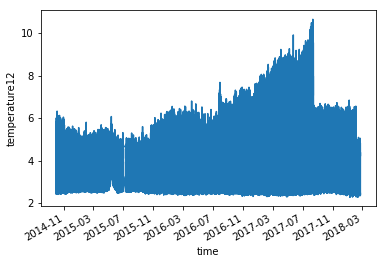

In [15]:
ds['temperature12'].plot()
plt.show()

We can tell that the peak temperature is increatsing, but this simple line plot does not reveal the internal data distribution. Let's convert to pandas dataframe and downsample from 1 Hz to 1/60 Hz. This step may take 5-10 minutes. More ram will be allocated during the workshop to expedite processing. If the step fails entirely for any reason, please send us a note on slack.

In [18]:
%%time
from dask.diagnostics import ProgressBar
with ProgressBar():
    df = ds['temperature12'].to_dataframe()
    df = df.resample('min').mean()

[########################################] | 100% Completed |  1min 27.8s
[########################################] | 100% Completed |  1min 59.0s
[########################################] | 100% Completed |  1min 49.5s
[########################################] | 100% Completed |  1min 58.9s
CPU times: user 8min 14s, sys: 1min 50s, total: 10min 4s
Wall time: 7min 45s


In [20]:
%%time
from dask.diagnostics import ProgressBar
with ProgressBar():
    df = ds['temperature18'].to_dataframe()
    df = df.resample('min').mean()

[########################################] | 100% Completed |  1min 30.9s
[########################################] | 100% Completed |  1min 58.5s
[########################################] | 100% Completed |  1min 57.6s
[########################################] | 100% Completed |  2min  6.4s
CPU times: user 8min 21s, sys: 1min 54s, total: 10min 15s
Wall time: 7min 56s


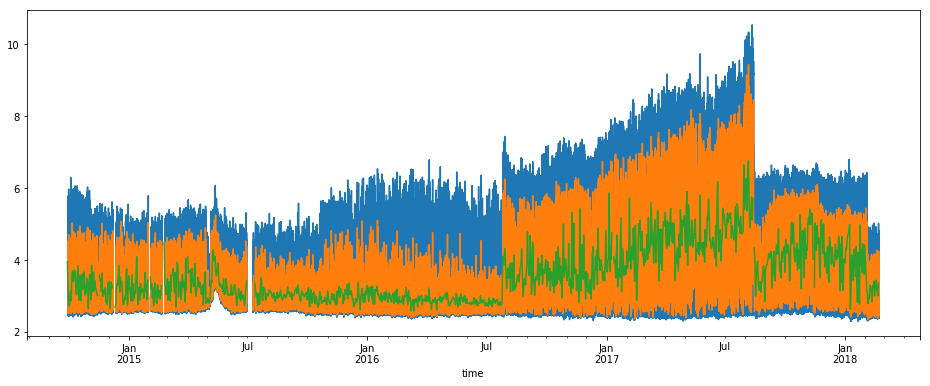

CPU times: user 9.04 s, sys: 0 ns, total: 9.04 s
Wall time: 8.64 s


In [19]:
%%time
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
df['temperature12'].plot(ax=ax)
df['temperature12'].resample('H').mean().plot(ax=ax)
df['temperature12'].resample('D').mean().plot(ax=ax)

df['temperature18'].plot(ax=ax)
df['temperature18'].resample('H').mean().plot(ax=ax)
df['temperature18'].resample('D').mean().plot(ax=ax)


plt.show()

Now we are getting a better sense of the data. Let's convert time to ordinal, grab temperature values and re-examine using hexagonal bi-variate binning. Again, this step may take a few minutes, but should run faster during the workshop. If the step fails entirely for any reason, please send us a note on slack.

In [21]:
%%time
time = []
time_pd = pd.to_datetime(ds.time.values.tolist())
for i in time_pd:
    i = np.datetime64(i).astype(datetime.datetime)
    time.append(dates.date2num(i)) 

CPU times: user 2min 13s, sys: 0 ns, total: 2min 13s
Wall time: 2min 13s


In [22]:
temperature = ds['temperature12'].values.tolist()

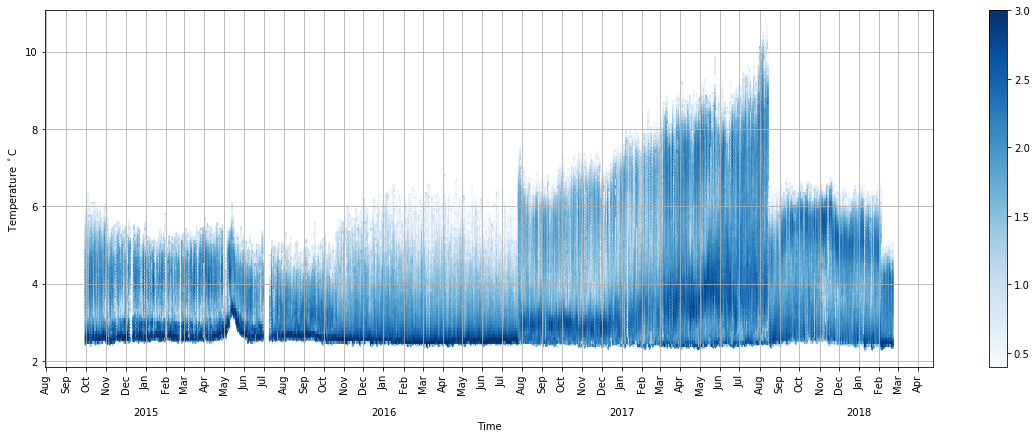

In [23]:
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

hb1 = ax.hexbin(time, temperature, bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Blues')
fig.colorbar(hb1)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
# ax.set_xlim(datetime.datetime(2015, 12, 1, 0, 0),datetime.datetime(2016, 7, 25, 0, 0))
# ax.set_ylim(2,11)
years = dates.YearLocator()
months = dates.MonthLocator()
yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(years)
ax.xaxis.set_minor_formatter(yearsFmt)
plt.tight_layout()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.ylabel('Temperature $^\circ$C')
plt.xlabel('Time')
plt.show()